In [1]:
import torch

a = torch.randn(1,1,5,3)
x = torch.randn(5,5,1,3)

In [2]:
c = a - x
c.shape

torch.Size([5, 5, 5, 3])

In [4]:
embed = torch.nn.Embedding(10, 3)

In [6]:
indices = torch.tensor([0, 1, 2, 3, 4])[None,None,None,:]
embed(indices)

tensor([[[[[-0.2024,  0.2619,  0.3574],
           [ 1.5205, -1.4985, -0.6328],
           [-1.2650, -0.5821,  1.6800],
           [ 0.6191,  0.0861, -2.1343],
           [ 1.1509,  0.0057, -1.9844]]]]], grad_fn=<EmbeddingBackward0>)

In [70]:
import torch
from torch import nn

class PixelTokenizer(torch.nn.Module):
    def __init__(self, vocab_size, image_size, low=0.0, high=1.0, per_channel=False, num_channels=3, most_common_classes=None, dim=768):
        super().__init__()
        self.low = low
        self.high = high
        self.per_channel = per_channel
        self.embed_table = nn.Embedding(vocab_size + 1, dim)
        self.mask_token_id = vocab_size
        self.num_channels = num_channels
        self.vocab_size = vocab_size
        self.h = self.w = image_size
        self.hw = image_size * image_size
        self.pos_embed = nn.Parameter(torch.randn(1, image_size * image_size * num_channels if per_channel else image_size * image_size,
                                                        dim) * 0.005)
        if per_channel:
            classes = torch.linspace(low, high, vocab_size)[None,None,:]
        else:
            classes = torch.tensor(most_common_classes)[None,None,:,:]

        self.register_buffer('classes', classes)

    def dists(self, x):
        classes = self.classes if len(self.classes.shape) == 4 else self.classes[...,None].repeat(1,1,1, self.num_channels)
        if self.per_channel:
            return (x.unsqueeze(-2) - classes).pow(2)
        else:
            return (x.unsqueeze(-2) - classes).pow(2).sum(-1, keepdim=True)

    def decode(self, indices, h, w):
        c = indices.shape[-1] // (h * w)
        if c > 1:
            indices = indices.reshape(-1, h * w, c)
            indices = indices.reshape(-1, h * w, c).reshape(-1, h, w, c).permute(0, 3, 1, 2)
            pixels = self.classes.squeeze()[indices]
        else:
            indices = indices.reshape(-1, h * w)
            pixels = self.classes.squeeze()[indices, :]
            c = pixels.shape[-1]
            pixels = pixels.reshape(-1, h, w, c).permute(0, 3, 1, 2)

        return pixels


    def encode(self, x):
        b, c, h, w = x.shape
        x = x.view(b, c, h * w).transpose(1, 2)
        indices = self.dists(x).argmin(-2)
        indices = indices.reshape(b, h * w * indices.shape[-1])
        return indices

    def to_embs(self, indices):
        b, hwc = indices.shape
        c = hwc // (self.hw)
        embeds = self.embed_table(indices) + self.pos_embed.expand(b, -1, -1)
        # b, hw, c * dim -> b, c * dim, h, w
        # embeds = embeds.permute(0, 2, 1).reshape(b, -1, self.h, self.w * 3)
        return embeds


In [71]:
most_common_classes = [
    [0.0, 0.5, 0.3],
    [0.8, 0.2, 0.1],
    [0.2, 0.1, 0.9],
    [0.1, 0.9, 0.2],
]

tokenizer = PixelTokenizer(3, 32, most_common_classes=most_common_classes)

In [72]:
img = torch.rand(1, 3, 32, 32)

In [73]:
indices = tokenizer.encode(img)

In [74]:
pixels = tokenizer.decode(indices, 32, 32)

In [111]:
import torch
import safetensors
import torch
import random
from torchvision import transforms as T
import torchvision
import faiss

def open_weights(path):
    try: # if ".safetensors" in path:
        state_dict = {}
        with safetensors.safe_open(path, "pt") as f:
            for k in f.keys():
                state_dict[k] = f.get_tensor(k)
    except:
        state_dict = torch.load(path, map_location="cpu")

    return state_dict


def get_kmeans_clusters(latents=None, dataset_name="cifar", k=256, image_size=32, num_images=2000, verbose=True, niter=100):
    transform = T.Compose(
        [T.ToTensor(),
         T.Resize(image_size),
         T.CenterCrop(image_size),]
    )

    dataset_classes = {
        "cifar": torchvision.datasets.CIFAR10,
        "celeb-a": torchvision.datasets.CelebA,
        "flowers102": torchvision.datasets.Flowers102,
    }
    dataset_cls = dataset_classes[dataset_name]
    dataset = dataset_cls(root='./data', #split='train',
                                 download=True, transform=transform)

    dataloader = torch.utils.data.DataLoader(
        dataset,
        shuffle=True,
        batch_size=64,
        num_workers=4,
         pin_memory=False
    )

    images = []
    for i, x in enumerate(dataloader):
        images.extend(x[0].chunk(x[0].size(0)))
        if len(images) >= num_images:
            break
    images = torch.cat(images, 0).permute(0, 2, 3, 1).reshape(-1, 3).numpy()
    c = 3 if dataset_name is None else latents.shape[-1]
        
    kmeans = faiss.Kmeans(c, k, niter=niter, verbose=verbose)
    kmeans.train(images)

    return kmeans


In [112]:
kmeans = get_kmeans_clusters("cifar", k=4096, image_size=32, num_images=2000)

Files already downloaded and verified
Sampling a subset of 1048576 / 2097152 for training
Clustering 1048576 points in 3D to 4096 clusters, redo 1 times, 100 iterations
  Preprocessing in 0.07 s
  Iteration 99 (17.96 s, search 11.95 s): objective=289.303 imbalance=1.530 nsplit=0       


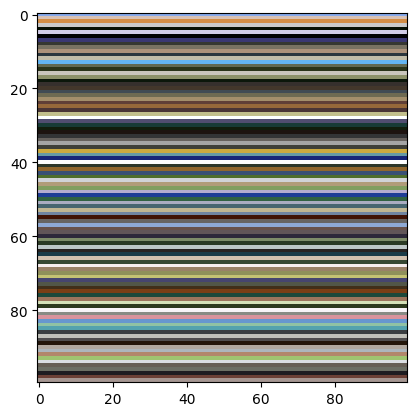

In [113]:
import matplotlib.pyplot as plt

centroids = torch.from_numpy(kmeans.centroids)[:,None,:]
centroids = centroids[:100].repeat_interleave(100,1)
plt.imshow(centroids)